# Daily Retreat: Using Sentiment Analysis to<br>Find, Personalize, and Share Positive News from Popular Online Sources
__Aaron Carr, Azucena Faus, and Dave Friesen - ADS-599-01-SU23__

In [1]:
__author__ = 'Aaron Carr, Azucena Faus, Dave Friesen'
__email__ = 'acarr@sandiego.edu, afaus@sandiego.edu, dfriesen@sandiego.edu'
__version__ = '1.0'
__date__ = 'July/August 2023'

## Setup

In [2]:
# Import basic and data access libraries
import numpy as np
import pandas as pd

# Import base model and evaluation libraries
from sklearn.model_selection import train_test_split

# Import transformeres, LLM libraries and support
import transformers

from huggingface_hub import login
import openai
from langchain import HuggingFacePipeline, PromptTemplate, LLMChain
from langchain.llms import OpenAI

# Import vector database (senmantic search) libraries
import tqdm; import warnings; warnings.filterwarnings("ignore", category=tqdm.TqdmExperimentalWarning)
import pinecone
from pinecone import ApiException

# Import visualization libraries
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import gaussian_kde

# Import utility libraries
import os
import time

In [3]:
# Set basic np, pd, and plt output defaults (keeping this code 'clean')
%run -i 'defaults.py'

In [4]:
warnings.filterwarnings(action='ignore', category=UserWarning, module='bitsandbytes')

## Data Load and Validation

In [5]:
# Instantiate and confirm master dataframe
news_00_df = pd.read_csv('../data/data_preprocessed_w_sw_2023-07-20_13-02-01408354.csv')

# Load pre-processed sentiment
news_05_df = pd.read_csv('../data/news-05.csv')
news_05_df = pd.merge(news_00_df, news_05_df, on='text_id')

# Load pre-processed embeddings as numpy array
embeddings = np.load('../data/embeddings.npy', allow_pickle=True)
news_05_df['embeddings'] = list(embeddings)

print(news_05_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36405 entries, 0 to 36404
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   text_id                   36405 non-null  int64  
 1   source_name               36405 non-null  object 
 2   author                    36196 non-null  object 
 3   title                     36405 non-null  object 
 4   url                       36405 non-null  object 
 5   publish_date              36405 non-null  object 
 6   article_text              36405 non-null  object 
 7   content                   36405 non-null  object 
 8   processed_text            36403 non-null  object 
 9   processed_text_split      36405 non-null  object 
 10  num_tokens                36405 non-null  int64  
 11  sentiment_vader           36405 non-null  object 
 12  sentiment_vader_compound  36405 non-null  float64
 13  sentiment_vader_cat       36405 non-null  object 
 14  sentim

## Sentiment Analysis: Model Eval

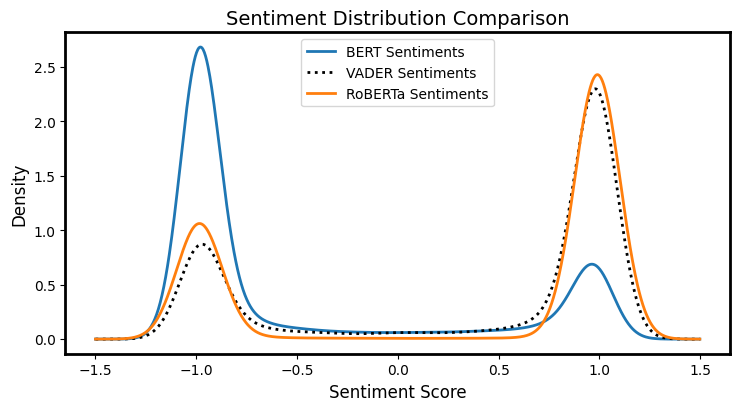

In [6]:
# Plot distribution comparison

min_sentiment = news_05_df['sentiment_roberta'].min()
max_sentiment = news_05_df['sentiment_roberta'].max()

# Compute KDE for 'sentiment_bert'
bert_kde = gaussian_kde(news_05_df['sentiment_bert'])
x_bert = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_bert = bert_kde(x_bert)
plt.plot(x_bert, y_bert, label='BERT Sentiments')

# Compute KDE for 'sentiment_vader_compound'
vadar_kde = gaussian_kde(news_05_df['sentiment_vader_compound'])
x_vadar = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_vadar = vadar_kde(x_vadar) * len(news_05_df['sentiment_bert']) / len(news_05_df['sentiment_vader_compound'])
plt.plot(x_vadar, y_vadar, linestyle='dotted', color='black', label='VADER Sentiments')

# Compute KDE for 'sentiment_roberta'
roberta_kde = gaussian_kde(news_05_df['sentiment_roberta'])
x_roberta = np.linspace(min_sentiment - 0.5, max_sentiment + 0.5, 1000)
y_roberta = roberta_kde(x_roberta)
plt.plot(x_roberta, y_roberta, label='RoBERTa Sentiments')

plt.title('Sentiment Distribution Comparison')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend()
plt.tight_layout()
plt.show()

In [7]:
news_05_df[:30][['title', 'sentiment_vader_compound', 'sentiment_bert', 'sentiment_roberta']]

,title,sentiment_vader_compound,sentiment_bert,sentiment_roberta
0,"Tito's launches 'Tito's in a Big Can,' an empty cocktail keg listed at $200",0.87,-0.98,1.00
1,Search for missing actor Julian Sands continues in 'limited capacity',0.98,0.96,0.99
2,Four star running back picks Michigan State over UNC,0.99,-0.97,0.99
3,Alabama center Charles Bediako signs one-year deal with San Antonio Spurs,0.98,0.99,0.99
4,Ralph Sampson breaks down iconic Boston Celtics-Houston Rockets fight in 1986 playoffs,0.67,0.82,1.00
5,Cowherd: Lakers are delusional for wanting to pay Austin Reaves big bucks,0.99,-0.09,0.99
6,Recruiting Roundup: Latest Alabama Football recruiting news,1.00,-0.97,0.99
7,Eagles’ 2023 training camp preview: Jalen Hurts joins an elite tier of NFL quarterbacks,0.59,-0.38,1.00
8,Lincoln Riley’s late-night emoji tweets equal four USC commits on Tuesday,0.92,-0.99,1.00
9,Washington passes California as most expensive state for gas: AAA,0.23,-1.00,-0.35


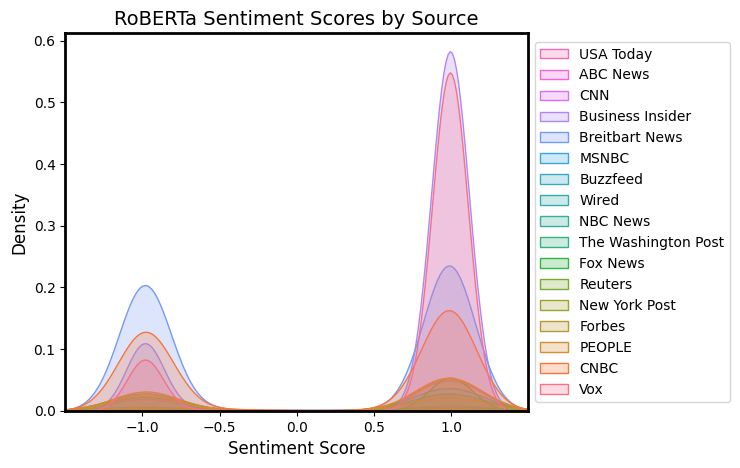

In [8]:
# Plot KDE of BERT
plt.figure(figsize=(7.5, 8.5 / (16 / 9)))
sns.kdeplot(data=news_05_df, x='sentiment_roberta', hue='source_name', fill=True)

plt.xlim(min_sentiment - 0.5, max_sentiment + 0.5)

plt.title('RoBERTa Sentiment Scores by Source')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')

plt.legend(labels=news_05_df['source_name'].unique(), loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

## Semantic Similarity (experimental)

In [ ]:
V_INDEX = 'news'

# Establish connection to Pinecone
pinecone.init(api_key=os.environ['PINECONE_API_KEY'], environment='us-west1-gcp-free')

indexes = pinecone.list_indexes()
if V_INDEX in indexes:
    print(f"The index '{V_INDEX}' exists.")
else:
    print(f"The index '{V_INDEX}' does not exist.")

In [ ]:
# Set index and refresh
index = pinecone.Index(V_INDEX)
index.describe_index_stats()

In [ ]:
# Query function
def query_vector(index, df, idx, top_k):
    vector = news_05_df.loc[idx, 'embeddings'].tolist()  # convert numpy array to list
    results = index.query(vector=vector, top_k=top_k, include_values=True)
    return results

# Usage example
results = query_vector(index, news_05_df, 11, 3)

# Extract ids from results and convert to integers
ids = [int(match['id']) for match in results['matches']]

# Get corresponding records from 'news_00_df'
records = news_05_df.loc[ids]

# Display 'article_title' for each record
for id, row in records.iterrows():
    print(f'ID: {id}, Title: {row["title"]}')

## Summarization (experimental)

In [ ]:
# Establish pre-trained model and pipeline
hf_token = os.getenv('HUGGINGFACEHUB_API_TOKEN')
login(token=hf_token)

model_id = 'meta-llama/Llama-2-7b-chat-hf'

model_config = transformers.AutoConfig.from_pretrained(
    model_id,
    token=hf_token
)

model = transformers.AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    config=model_config,
    token=hf_token
)

tokenizer = transformers.AutoTokenizer.from_pretrained(
    model_id,
    token=hf_token
)

# Create a text generation pipeline
gen_pipe = transformers.pipeline(
    'text-generation',
    model=model,
    tokenizer=tokenizer,
    torch_dtype=torch.bfloat16,
    max_length=1024
)

llm = HuggingFacePipeline(pipeline=gen_pipe, model_kwargs={'temperature': 0})

In [ ]:
start_time = time.time()

template = """
Write a one-sentence summary of the following text delimited by triple backquotes.
'''{text}'''
ONE-SENTENCE-ONLY SUMMARY:
"""

prompt = PromptTemplate(template=template, input_variables=['text'])

llm_chain = LLMChain(prompt=prompt, llm=llm)

def get_first_n_chars(text, n):
    if len(text) <= n:
        return text
    else:
        short_text = text[:n]
        return short_text.rsplit(' ', 1)[0]

selected_rows = news_05_df.loc[0:19].copy()

summaries = []
for _, row in selected_rows.iterrows():
    text = get_first_n_chars(row['processed_text'], 200)
    input_dict = {'text': text}
    summary = llm_chain.run(input_dict)
    summaries.append(summary)

selected_rows['summary'] = summaries
    
stop_time = time.time()
elapsed_time = (stop_time - start_time) / 60.0
print(f'Start time: {time.ctime(start_time)}')
print(f'Stop time: {time.ctime(stop_time)}')
print(f"Elapsed time: {format(elapsed_time, '.2f')} minutes")
    
selected_rows.head(10)

## Other (experimentation)

In [ ]:
# Establish OpenAI connection
#openai_organization = os.getenv('OPENAI_ORG')
#openai_api_key = os.getenv('OPENAI_API_KEY')

# Experiment with a simple, related question:-)
llm = OpenAI(openai_api_key = os.getenv('OPENAI_API_KEY'),
             model_name='text-davinci-003')
print(llm('What is news sentiment analysis?'))

## Data Partitioning (retained but not used here)

In [ ]:
# Set splits
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

# Split and profile
train_df, test_df = train_test_split(news_04_df, test_size=1-train_ratio,
                                     random_state=42)
val_df, test_df = train_test_split(test_df, test_size=test_ratio/(test_ratio+val_ratio),
                                   random_state=42)